In [8]:
import subprocess
import random
import numpy as np
import time
import os
import csv
import matplotlib.pyplot as plt
import glob

In [13]:
def generateArray(size, seed=None):
    random.seed(seed)
    if os.path.isfile(f"data/array-{size}.txt"): return
    with open(f"data/array-{size}.txt", "w") as f:
        for i in np.arange(size, 0, -1, dtype=np.int64): f.write(str(i) + ' ')

def compile(source_file):
    start_time = time.time()
    process = subprocess.Popen(["g++", "./lib/System.cpp", f'algorithms/{source_file}', "-o", f'./bin/{source_file[:-4]}', "-lpapi", "-O0", "-I./lib/", "-I.", "-lm"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    end_time = (time.time() - start_time)
    print(f"Compile time: {end_time}s")
    if stderr:
        print("Error:\n" + stderr.decode("utf-8"))
        return False
    else:
        print("Compiled with success")
        return True

def run(source_file, args, array_size, log=False):
    start_time = time.time()
    process = subprocess.Popen(["./bin/"+source_file[:-4], *args.split()], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    end_time = (time.time() - start_time)
    if log: print(f"{array_size} run time: {end_time}s")
    if stderr:
        if log:
            print("Error:\n" + stderr.decode("utf-8"))
        return False
    else:
        if log: 
            print("Runned with success")
            print('stdout:\n' + stdout.decode("utf-8"))
        return True

def plotData(filename, title):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        line_count = 0
        array_size = []
        time_spent = []
        PAPI_TOT_CYC = []
        PAPI_REF_CYC = []
        PAPI_L3_TCM = []
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                array_size.append(int(row[0]))
                time_spent.append(float(row[1]))
                PAPI_TOT_CYC.append(int(row[2]))
                PAPI_REF_CYC.append(int(row[3]))
                PAPI_L3_TCM.append(int(row[4]))
                line_count += 1
        # print(f'Processed {line_count} lines.')
        plt.figure(figsize=(30, 20))
        plt.plot(array_size, time_spent)
        # plt.plot(array_size, PAPI_TOT_CYC)
        # plt.plot(array_size, PAPI_REF_CYC)
        # plt.plot(array_size, PAPI_L3_TCM)
        plt.xticks(np.arange(min(array_size), max(array_size)+128, 128**1.7))
        # plt.yticks(np.arange(min(time_spent), max(time_spent)+1, 0.002**2))
        plt.xlabel('Array size')
        plt.ylabel('Time spent(s)')
        plt.title(title)
        plt.show()

def generateResultFile(filename, headers):
    data_filename = f'results/result_{filename[:-4]}.txt'
    if os.path.exists(data_filename):
        os.remove(data_filename)
    with open(data_filename, 'w') as data_file:
        data_file.write(headers)

def clean_data_files():
    files = glob.glob('data/*')
    print("Cleaning data/ ~")
    for f in files:
        os.remove(f)

In [15]:
filename = 'quick_sort.cpp'
if compile(filename):
    generateResultFile(filename, 'array_size;time_spent(s);PAPI_TOT_CYC;PAPI_REF_CYC;PAPI_L3_TCM\n')

    for array_size in np.arange(2048, 128000+1, 128):
        generateArray(size=array_size)
        run(filename, f'./data/array-{array_size}.txt {array_size}', array_size);
    
    plotData('results/result_quick_sort.txt', 'Quick Sort\nArray size X Time spent(s)')

Compile time: 0.9477460384368896s
Compiled with success


Compile time: 0.840587854385376s
Compiled with success
Column names are array_size, time_spent(s), PAPI_TOT_CYC, PAPI_REF_CYC, PAPI_L3_TCM


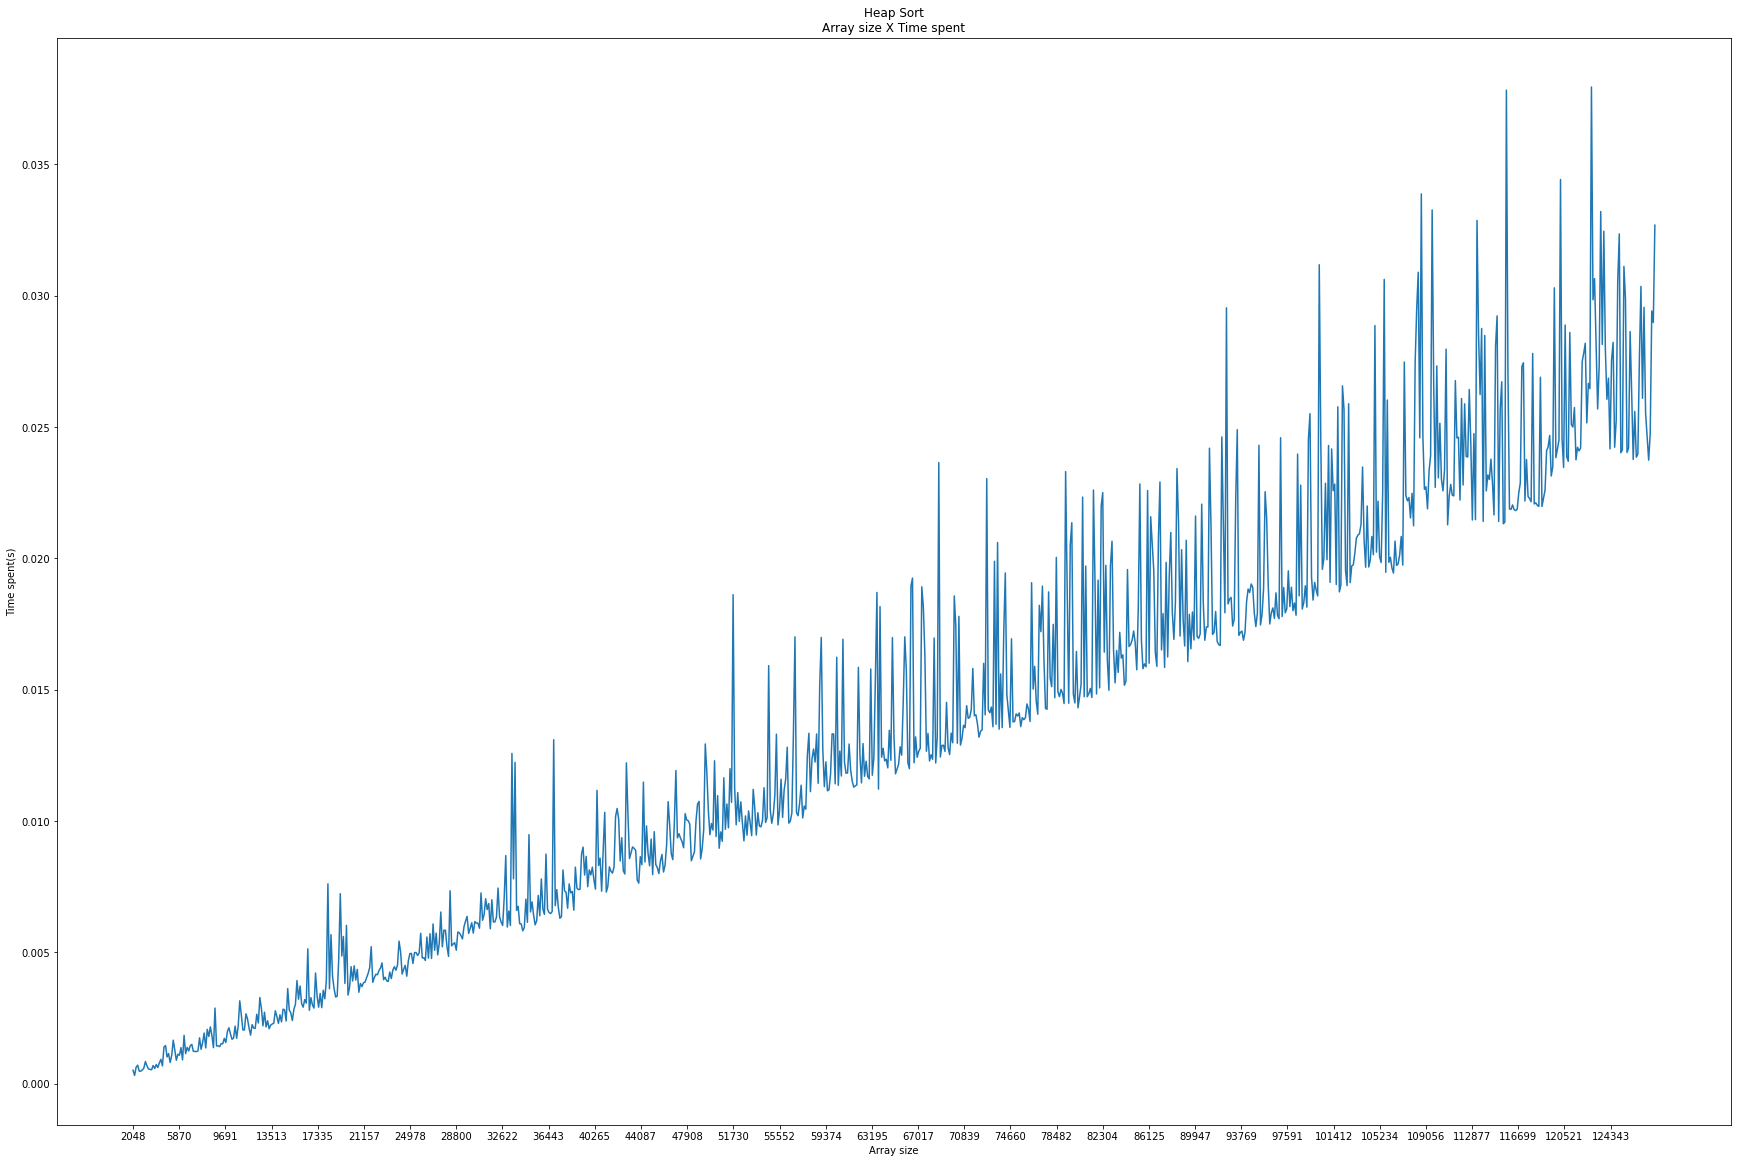

In [5]:
filename = 'heap_sort.cpp'
if compile(filename):
    generateResultFile(filename, 'array_size;time_spent(s);PAPI_TOT_CYC;PAPI_REF_CYC;PAPI_L3_TCM\n')

    for array_size in np.arange(2048, 128000+1, 128):
        generateArray(size=array_size)
        run(filename, f'./data/array-{array_size}.txt {array_size}', array_size);
    
    plotData('results/result_heap_sort.txt', 'Heap Sort\nArray size X Time spent')

In [ ]:
# clean_data_files()